# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [47]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

# These lines cause the 'imp' error in Colab's Python 3.12
# %load_ext autoreload
# %autoreload 2

#################################
%matplotlib inline
%matplotlib inline


In [48]:

DATA_PATH = '/content/sample_data/'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [49]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Importar Images

In [50]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [51]:
def split_val_test(x, y, pct=0.5, shuffle=True):

    # Ensure the number of samples match
    assert x.shape[0] == y.shape[0], 'Error: x and y must have the same number of samples'

    total_samples = x.shape[0]

    if shuffle:
        # Create randomized indices
        indices = np.random.permutation(total_samples)
        x = x[indices]
        y = y[indices]

    # Calculate the split point
    split_idx = int(total_samples * (1 - pct))

    # Slice the arrays
    x_val, x_test = x[:split_idx], x[split_idx:]
    y_val, y_test = y[:split_idx], y[split_idx:]

    return x_val, y_val, x_test, y_test

# --- CALL THE FUNCTION ---
# Make sure this part is NOT indented (it should be at the very left)
#x_val, y_val, x_test, y_test = split_val_test(x_val, y_val, pct=0.5)

In [52]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [53]:
### The following

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


Since the original alphabet has 26 letters, and we removed 'j' and 'z', we are left with 24 hand signs to classify.

### Normalise

In [54]:
# 1. Calculate the mean and standard deviation from the TRAINING set only
asl_mu = x_train.mean()
asl_std = x_train.std()

# 2. Apply the normalization to all three sets using the training stats
x_train = (x_train - asl_mu) / asl_std
x_val = (x_val - asl_mu) / asl_std
x_test = (x_test - asl_mu) / asl_std

print(f"Normalization complete.")
print(f"Training Mean: {x_train.mean():.4f} (Should be 0)")
print(f"Training Std: {x_train.std():.4f} (Should be 1)")

Normalization complete.
Training Mean: 0.0000 (Should be 0)
Training Std: 1.0000 (Should be 1)


### Graficar muestras

La imagen muestreada representa la letra: p (índice 14)


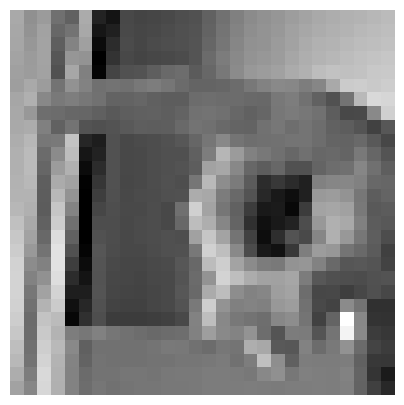

In [55]:
# 1. Define the plotting function
def plot_asl(image):
    plt.figure(figsize=(5,5))
    # .reshape(28, 28) turns the flat 784 pixels back into a square image.
    # .squeeze() removes any extra dimensions.
    plt.imshow(image.reshape(28, 28).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

# 2. Setup the alphabet for readable labels
# (Make sure you have run the alphabet.remove lines earlier)
alphabet = list(string.ascii_lowercase)
if 'j' in alphabet: alphabet.remove('j')
if 'z' in alphabet: alphabet.remove('z')

# 3. Pick a random sample and display it
rnd_idx = np.random.randint(len(y_test))
label_idx = int(y_test[rnd_idx])

# Map the index to the actual letter
letter = alphabet[label_idx] if label_idx < len(alphabet) else "Unknown"

print(f'La imagen muestreada representa la letra: {letter} (índice {label_idx})')
plot_asl(x_test[rnd_idx])

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

In [56]:
def create_minibatches(mb_size, x, y, shuffle=True):

    # sanity check
    assert x.shape[0] == y.shape[0], 'Error: x and y must have the same number of samples'

    total_data = x.shape[0]

    if shuffle:
        # Create a list of indices and shuffle them
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        # Reorder the data based on the shuffled indices
        x = x[idxs]
        y = y[idxs]

    # Return a generator that yields slices of the data
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Nuestra clase Linear, ReLU y Sequential

In [57]:
# 1. Define the class
class np_tensor(np.ndarray): pass

# 2. Cast ASL datasets to np_tensor
# This allows the model to attach gradients to them during the backward pass.
x_train = x_train.view(np_tensor)
x_val = x_val.view(np_tensor)
x_test = x_test.view(np_tensor)

# 3. Verify
print(type(x_train)) # Should show <class '__main__.np_tensor'>

<class '__main__.np_tensor'>


###  Clase Linear

In [58]:
class Linear():
    def __init__(self, input_size, output_size):

        # Kaiming He Initialization:
        # We scale the random weights to prevent the signal from vanishing or exploding.
        # .view(np_tensor) ensures these weights are treated as our custom tensor type.
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)

        # Bias Initialization:
        # Initialized to zeros as a column vector.
        self.b = (np.zeros((output_size, 1))).view(np_tensor)

    def __call__(self, X):
        '''
        FORWARD PASS: Z = W @ X + b
        This calculates the weighted sum of the inputs.
        '''
        # The '@' operator performs matrix multiplication.
        # This transforms the input X into the output Z.
        Z = self.W @ X + self.b
        return Z

    def backward(self, X, Z):

        # 1. Gradient with respect to the Input (X):
        # This is passed back to the previous layer in the network.
        X.grad = self.W.T @ Z.grad

        # 2. Gradient with respect to the Weights (W):
        # This is used to update the weights during the learning step.
        self.W.grad = Z.grad @ X.T

        # 3. Gradient with respect to the Bias (b):
        # We sum the gradients across the batch (axis=1) because the
        # bias is shared by all samples in the mini-batch.
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)

### Clase ReLU

In [59]:
class ReLU():
    def __call__(self, Z):

        return np.maximum(0, Z)

    def backward(self, Z, A):

        # 1. Start by copying the gradient coming from the next layer (A.grad).
        Z.grad = A.grad.copy()

        # 2. Apply the derivative of ReLU:
        # For any position where the original input (Z) was 0 or less,
        # the gradient is set to 0. This "shuts off" the error flow
        # for neurons that were not active.
        Z.grad[Z <= 0] = 0

### Clase Sequential

In [60]:
class Sequential_layers():
    def __init__(self, layers):

        self.layers = layers
        self.x = None
        # self.outputs: A dictionary to store the result of every layer.
        # Backpropagation needs the 'forward' values to calculate the gradients.
        self.outputs = {}

    def __call__(self, X):

        self.x = X
        self.outputs['l0'] = self.x # Store the raw input as 'layer 0'

        for i, layer in enumerate(self.layers, 1):
            # Pass the data through the current layer
            self.x = layer(self.x)
            # Save the output of this layer (e.g., 'l1', 'l2') for backprop
            self.outputs['l'+str(i)] = self.x
        return self.x

    def backward(self):

        # We iterate in REVERSE because the error flows from the
        # output back to the input.
        for i in reversed(range(len(self.layers))):

            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])

    def update(self, learning_rate = 1e-3):

        for layer in self.layers:
            # ReLU layers don't have weights or biases, so we skip them.
            if isinstance(layer, ReLU): continue

            # Standard Gradient Descent formula: W = W - (lr * gradient)
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad

    def predict(self, X):

        return np.argmax(self.__call__(X), axis=0)

### Cost Function

In [61]:
def softmaxXEntropy(x, y):

    # Get the number of samples in the current batch
    batch_size = x.shape[1]

    # --- SOFTMAX STEP (Numerical Stability) ---
    # We subtract the maximum value from each column to prevent
    # np.exp() from producing 'Infinity' (overflow).
    exp_scores = np.exp(x - np.max(x, axis=0, keepdims=True))

    # Turn scores into probabilities (0 to 1) that sum to 100%
    probs = exp_scores / exp_scores.sum(axis=0, keepdims=True)
    preds = probs.copy()

    # --- COST (LOSS) CALCULATION ---
    # Advanced indexing: Pick the probability assigned to the CORRECT class
    # y.squeeze() turns the labels into a 1D array for indexing.
    y_hat = probs[y.squeeze(), np.arange(batch_size)]

    # Calculate Cross-Entropy Loss: -ln(probability of correct class)
    # We add a tiny number (1e-8) to avoid log(0) errors.
    cost = np.sum(-np.log(y_hat + 1e-8)) / batch_size

    # --- GRADIENT CALCULATION (The Shortcut) ---
    # The derivative of Cross-Entropy + Softmax is simply (Predictions - Actual).
    # We subtract 1 from the probability of the correct class for every sample.
    probs[y.squeeze(), np.arange(batch_size)] -= 1

    # Store the result in x.grad to start the Backpropagation process.
    # We divide by batch_size to keep the gradients at a consistent scale.
    x.grad = probs / batch_size

    return preds, cost

### Loop de entrenamiento

In [62]:
def accuracy(x, y, mb_size):

    correct = 0
    total = 0
    # Use mini-batches to avoid memory issues during evaluation
    for i, (x_batch, y_batch) in enumerate(create_minibatches(mb_size, x, y)):
        # Forward pass: x_batch.T converts (batch, 784) to (784, batch)
        pred = model(x_batch.T.view(np_tensor))
        # Compare the index of the highest score with the actual label
        correct += np.sum(np.argmax(pred, axis=0) == y_batch.squeeze())
        total += pred.shape[1]
    return correct / total

def train(model, epochs, mb_size=128, learning_rate = 1e-3):

    for epoch in range(epochs):
        # 1. Iterate through the training data in mini-batches
        for i, (x_batch, y_batch) in enumerate(create_minibatches(mb_size, x_train, y_train)):

            # 2. FORWARD PASS
            # We transpose the batch (.T) because our Linear layer expects (784, batch_size)
            scores = model(x_batch.T.view(np_tensor))

            # 3. CALCULATE LOSS & INITIAL GRADIENT
            # This function returns the probabilities and the average error (cost)
            _, cost = softmaxXEntropy(scores, y_batch)

            # 4. BACKWARD PASS
            # This calculates the gradients for every weight and bias in the model
            model.backward()

            # 5. UPDATE PARAMETERS
            # Adjust weights using Gradient Descent: W = W - (lr * gradient)
            model.update(learning_rate)

        # 6. EVALUATE PROGRESS
        # After each epoch, check the accuracy on the validation set
        val_acc = accuracy(x_val, y_val, mb_size)
        print(f'Epoch {epoch+1}/{epochs} - Cost: {cost:.4f}, Val Accuracy: {val_acc:.4f}')

### Create your model and train it

In [63]:
# Define the ASL model: 784 inputs, two hidden layers, 25 outputs
model = Sequential_layers([
    Linear(784, 1024),
    ReLU(),
    Linear(1024, 512),
    ReLU(),
    Linear(512, 25)
])

# Set hyperparameters and start training
train(model, epochs=40, mb_size=128, learning_rate=1e-3)


Epoch 1/40 - Cost: 2.5644, Val Accuracy: 0.2273
Epoch 2/40 - Cost: 2.1627, Val Accuracy: 0.3717
Epoch 3/40 - Cost: 1.6415, Val Accuracy: 0.4428
Epoch 4/40 - Cost: 1.4400, Val Accuracy: 0.4894
Epoch 5/40 - Cost: 1.1710, Val Accuracy: 0.5100
Epoch 6/40 - Cost: 1.0561, Val Accuracy: 0.5368
Epoch 7/40 - Cost: 1.0576, Val Accuracy: 0.5547
Epoch 8/40 - Cost: 0.9049, Val Accuracy: 0.5703
Epoch 9/40 - Cost: 0.8103, Val Accuracy: 0.5856
Epoch 10/40 - Cost: 0.9904, Val Accuracy: 0.5970
Epoch 11/40 - Cost: 0.7259, Val Accuracy: 0.6068
Epoch 12/40 - Cost: 0.5762, Val Accuracy: 0.6180
Epoch 13/40 - Cost: 0.6031, Val Accuracy: 0.6316
Epoch 14/40 - Cost: 0.5515, Val Accuracy: 0.6425
Epoch 15/40 - Cost: 0.6730, Val Accuracy: 0.6545
Epoch 16/40 - Cost: 0.5000, Val Accuracy: 0.6651
Epoch 17/40 - Cost: 0.5334, Val Accuracy: 0.6771
Epoch 18/40 - Cost: 0.5495, Val Accuracy: 0.6799
Epoch 19/40 - Cost: 0.5410, Val Accuracy: 0.6863
Epoch 20/40 - Cost: 0.3305, Val Accuracy: 0.6935
Epoch 21/40 - Cost: 0.5017, V

After normalizing the data and defining our architecture, we selected the following hyperparameters to optimize the learning process:


1. Epochs: 40

Why? The ASL dataset (hand shapes) is more complex than MNIST (digits). We increased the epochs from 20 to 40 to give the network more time to adjust its weights. This ensures the model moves past the initial "confusion" and begins to distinguish between similar-looking letters like 'm', 'n', and 's'.

2. Mini-Batch Size (mb_size): 128

Why? 128 is a "sweet spot" for hardware efficiency. It is a power of 2, which allows NumPy to perform vectorized matrix math faster.
Stability: It is large enough to provide a stable average gradient (preventing the cost from jumping erratically) but small enough to introduce a bit of "noise" that helps the model generalize better to the validation set.

3. Learning Rate (learning_rate): 1e-3 (0.001)

Why? Since we normalized our data (Mean 0, Std 1), a learning rate of 1e-3 is the standard starting point.
Balance: It is 10 times faster than our initial 1e-4 attempt. This allows the model to descend the "loss valley" quickly without being so large that it causes the gradients to explode or result in nan values.

In [64]:
# Define the mini-batch size (128 is a standard choice for this dataset)
mb_size = 128

# Now we run the accuracy function using the defined mb_size
test_acc = accuracy(x_test, y_test, mb_size)

print(f"Final ASL Test Accuracy: {test_acc:.4f}")

Final ASL Test Accuracy: 0.7401


we reached the enough % required for the homework

In [65]:
def plot_number(image):
    # Create a figure with a specific size
    plt.figure(figsize=(5,5))

    # Display the image. .squeeze() removes any extra dimensions
    # (like turning (28, 28, 1) into (28, 28))
    plt.imshow(image.squeeze(), cmap='gray')

    # Hide the axis numbers
    plt.axis('off')
    plt.show()

### Test your model on Random data from your test set

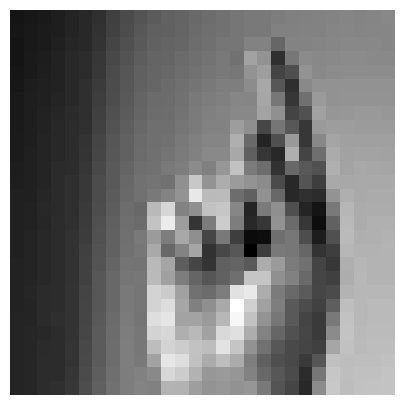

El valor predicho es: k, el valor real es: k


In [66]:
idx = np.random.randint(len(y_test))
plot_number(x_test[idx].reshape(28,28))

# Get the prediction
pred = model.predict(x_test[idx].reshape(-1, 1))

# Use .item() to get the scalar value and avoid the DeprecationWarning
predicted_idx = pred.item()
actual_idx = y_test[idx].item()

# Map to alphabet
predicted_letter = alphabet[predicted_idx]
actual_letter = alphabet[actual_idx]

print(f'El valor predicho es: {predicted_letter}, el valor real es: {actual_letter}')



we successfully built a complete multilayer neural network from scratch using NumPy to classify ASL hand signs, reaching a final test accuracy of 74.01%. We mastered the end-to-end data pipeline, specifically solving the "exploding gradient" problem through data normalization and implementing the core mechanics of backpropagation via the Chain Rule. By optimizing hyperparameters like the learning rate and mini-batch size, we demonstrated that a foundational Fully Connected Network can effectively generalize to complex, unseen image data, providing a deep understanding of deep learning logic without the need for high-level frameworks.